--- Crop Yield Prediction Pipeline Initialized (Log-Transformed Target) ---
Data loaded: (13130, 9)
Applying Log-Transformation to Target (fixes RMSPE for low-yield crops)...

--- Step 2: Preprocessing ---
Fitting trend models (Log-Linear)...
Preprocessing complete.

--- Step 3: ML Data Preparation ---

--- Step 4: Deep Learning Data Preparation ---


[I 2025-11-20 01:09:13,458] A new study created in memory with name: no-name-17d5c156-08b2-415c-ae3b-9ed779edc29a



--- Step 5: Model Tuning ---
Tuning XGB...


[I 2025-11-20 01:09:13,874] Trial 0 finished with value: 40.95296204254464 and parameters: {'n_estimators': 653, 'max_depth': 6, 'learning_rate': 0.015683569199322945, 'subsample': 0.8132095797143929, 'colsample_bytree': 0.6737156306471911, 'min_child_weight': 27}. Best is trial 0 with value: 40.95296204254464.
[I 2025-11-20 01:09:14,314] Trial 1 finished with value: 40.87595540413498 and parameters: {'n_estimators': 354, 'max_depth': 5, 'learning_rate': 0.014237753973502175, 'subsample': 0.8389998725058163, 'colsample_bytree': 0.7078426307875012, 'min_child_weight': 28}. Best is trial 1 with value: 40.87595540413498.
[I 2025-11-20 01:09:14,736] Trial 2 finished with value: 41.79652689424922 and parameters: {'n_estimators': 489, 'max_depth': 5, 'learning_rate': 0.0122964892592379, 'subsample': 0.8871100442942859, 'colsample_bytree': 0.8261655487617348, 'min_child_weight': 14}. Best is trial 1 with value: 40.87595540413498.
[I 2025-11-20 01:09:15,022] Trial 3 finished with value: 39.950

  Best RMSPE: 39.95%


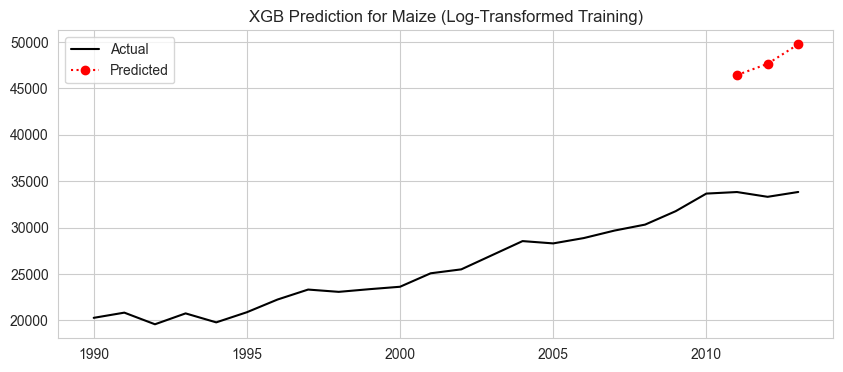

[I 2025-11-20 01:09:16,872] A new study created in memory with name: no-name-9769e412-eff0-4db6-b8f9-8442fb0ace6a


Tuning LSTM...


[I 2025-11-20 01:09:20,043] Trial 0 finished with value: 39.974174283572204 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.2556960649141516, 'lr': 0.002080496301614767, 'weight_decay': 0.007108636372229667}. Best is trial 0 with value: 39.974174283572204.
[I 2025-11-20 01:09:22,899] Trial 1 finished with value: 39.96011370109304 and parameters: {'lstm_units': 64, 'dense_units': 16, 'dropout': 0.33521939473772644, 'lr': 0.005712853357118911, 'weight_decay': 0.00014424355146172802}. Best is trial 1 with value: 39.96011370109304.
[I 2025-11-20 01:09:24,986] Trial 2 finished with value: 39.913404375579255 and parameters: {'lstm_units': 64, 'dense_units': 16, 'dropout': 0.23079545770457802, 'lr': 0.0035399847592927965, 'weight_decay': 0.0006155489559203184}. Best is trial 2 with value: 39.913404375579255.
[I 2025-11-20 01:09:27,831] Trial 3 finished with value: 39.87080405075368 and parameters: {'lstm_units': 32, 'dense_units': 16, 'dropout': 0.43778190635365516, 'lr': 0

  Best RMSPE: 39.85%


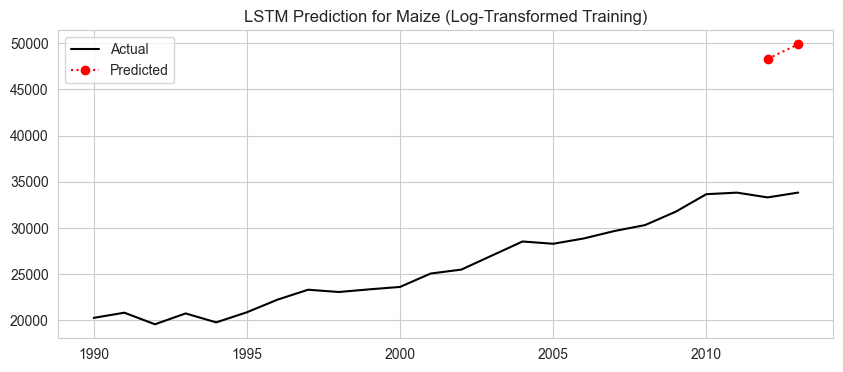

  Model  RMSPE (%)        R2
0   XGB  53.214869  0.814841
1  LSTM  60.032757  0.784635


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
import optuna
import xgboost as xgb
import shap
import torch
import torch.nn as nn
import torch.optim as optim

from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Configuration
np.random.seed(42)
torch.manual_seed(42)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

print("--- Crop Yield Prediction Pipeline Initialized (Log-Transformed Target) ---")

# ==========================================
# 0. HELPER FUNCTIONS
# ==========================================

def calculate_rmspe(y_true, y_pred):
    """Root Mean Squared Percentage Error"""
    # y_true and y_pred must be in ORIGINAL scale (not log, not scaled)
    return np.sqrt(np.mean(((y_true - y_pred) / (y_true + 1e-8)) ** 2)) * 100

def reconstruct_yield_from_log(y_pred_scaled, reference_df, y_scaler):
    """
    Reverses the pipeline:
    1. Inverse Standard Scaler -> Gets Log-Detrended value
    2. Add Log-Trend -> Gets Log-Yield
    3. Exponentiate (np.expm1) -> Gets Actual Yield (hg/ha)
    """
    # 1. Inverse Scale
    if y_pred_scaled.ndim == 1: y_pred_scaled = y_pred_scaled.reshape(-1, 1)
    y_pred_log_det = y_scaler.inverse_transform(y_pred_scaled).flatten()
    
    # 2. Add Trend (which is now a trend on log data)
    y_pred_log = y_pred_log_det + reference_df['yield_trend'].values
    
    # 3. Inverse Log
    return np.expm1(y_pred_log)

# ==========================================
# 1. DATA LOADING & LOG TRANSFORMATION
# ==========================================

# Configuration Constants
TRAIN_END = 2007
VAL_END = 2010
LOOKBACK = 5
TARGET = 'hg/ha_yield'
TIME_COL = 'Year'
CAT_COLS = ['Area', 'Item']
BASE_NUMERIC_COLS = [
    'average_rain_fall_mm_per_year', 
    'pesticides_tonnes', 
    'avg_temp', 
    'fertilizer_kg/ha', 
    'solar_radiation_MJ/m2-day'
]

# Load Data
try:
    df = pd.read_csv("cleaned_crop_data.csv")
    print(f"Data loaded: {df.shape}")
    
    # --- CRITICAL FIX: LOG TRANSFORM TARGET ---
    # This compresses the range. Predicting Log(Yield) minimizes RMSPE inherently.
    print("Applying Log-Transformation to Target (fixes RMSPE for low-yield crops)...")
    df[TARGET] = np.log1p(df[TARGET])
    
except FileNotFoundError:
    raise FileNotFoundError("Error: 'cleaned_crop_data.csv' not found.")

# ==========================================
# 2. PREPROCESSING & FEATURE ENGINEERING
# ==========================================

print("\n--- Step 2: Preprocessing ---")

# 2.1 Split Data (Chronological)
train_df_orig = df[df[TIME_COL] <= TRAIN_END].copy()
val_df_orig = df[(df[TIME_COL] > TRAIN_END) & (df[TIME_COL] <= VAL_END)].copy()
test_df_orig = df[df[TIME_COL] > VAL_END].copy()

# 2.2 Label Encoding
le_area = LabelEncoder().fit(train_df_orig['Area'])
le_item = LabelEncoder().fit(train_df_orig['Item'])

for d in [train_df_orig, val_df_orig, test_df_orig]:
    d['Area_Encoded'] = d['Area'].apply(lambda x: le_area.transform([x])[0] if x in le_area.classes_ else 0)
    d['Item_Encoded'] = d['Item'].apply(lambda x: le_item.transform([x])[0] if x in le_item.classes_ else 0)

# 2.3 Detrending (Now on Log Data -> Represents Exponential Trend Removal)
print("Fitting trend models (Log-Linear)...")
trend_models = {}
global_trend_model = LinearRegression().fit(train_df_orig[[TIME_COL]], train_df_orig[TARGET])

for group, group_df in train_df_orig.groupby(CAT_COLS):
    if len(group_df) > 1:
        model = LinearRegression().fit(group_df[[TIME_COL]], group_df[TARGET])
        trend_models[group] = model

for d in [train_df_orig, val_df_orig, test_df_orig]:
    d['yield_trend'] = 0.0
    for group, group_df in d.groupby(CAT_COLS):
        model = trend_models.get(group, global_trend_model)
        d.loc[group_df.index, 'yield_trend'] = model.predict(group_df[[TIME_COL]])
    d['yield_detrended'] = d[TARGET] - d['yield_trend']

# 2.4 Feature Lagging
full_df = pd.concat([train_df_orig, val_df_orig, test_df_orig]).sort_values(CAT_COLS + [TIME_COL])
cols_to_lag = ['yield_detrended'] + BASE_NUMERIC_COLS

for col in cols_to_lag:
    for lag in [1, 2]:
        full_df[f'{col}_lag{lag}'] = full_df.groupby(CAT_COLS)[col].shift(lag)

full_df = full_df.dropna()

train_df = full_df[full_df[TIME_COL] <= TRAIN_END].copy()
val_df = full_df[(full_df[TIME_COL] > TRAIN_END) & (full_df[TIME_COL] <= VAL_END)].copy()
test_df = full_df[full_df[TIME_COL] > VAL_END].copy()

# 2.5 Scaling
feature_cols = [c for c in train_df.columns if c in BASE_NUMERIC_COLS or '_lag' in c]
x_scaler = StandardScaler()
y_scaler = StandardScaler() # Scales the Log-Detrended Yield

train_df[feature_cols] = x_scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols] = x_scaler.transform(val_df[feature_cols])
test_df[feature_cols] = x_scaler.transform(test_df[feature_cols])

train_df['yield_detrended'] = y_scaler.fit_transform(train_df[['yield_detrended']])
val_df['yield_detrended'] = y_scaler.transform(val_df[['yield_detrended']])
test_df['yield_detrended'] = y_scaler.transform(test_df[['yield_detrended']])

print("Preprocessing complete.")

# ==========================================
# 3. ML SPECIFIC PREPARATION
# ==========================================
print("\n--- Step 3: ML Data Preparation ---")

ml_cols = feature_cols + ['Area_Encoded', 'Item_Encoded']
X_train_ml = train_df[ml_cols].copy()
y_train_ml = train_df['yield_detrended']
X_val_ml = val_df[ml_cols].copy()
y_val_ml = val_df['yield_detrended']
X_test_ml = test_df[ml_cols].copy()
y_test_ml = test_df['yield_detrended']

# Drop Leakage
drop_cols = ['yield_detrended_lag1', 'yield_detrended_lag2']
X_train_ml = X_train_ml.drop(columns=drop_cols, errors='ignore')
X_val_ml = X_val_ml.drop(columns=drop_cols, errors='ignore')
X_test_ml = X_test_ml.drop(columns=drop_cols, errors='ignore')

# Target Encoding (On Log Data)
temp_train = X_train_ml.copy()
temp_train['target'] = y_train_ml
area_means = temp_train.groupby('Area_Encoded')['target'].mean()
item_means = temp_train.groupby('Item_Encoded')['target'].mean()
global_mean = y_train_ml.mean()

for df_ml in [X_train_ml, X_val_ml, X_test_ml]:
    df_ml['Area_Target_Mean'] = df_ml['Area_Encoded'].map(area_means).fillna(global_mean)
    df_ml['Item_Target_Mean'] = df_ml['Item_Encoded'].map(item_means).fillna(global_mean)
    df_ml.drop(columns=['Area_Encoded', 'Item_Encoded'], inplace=True)

# ==========================================
# 4. DL SPECIFIC PREPARATION
# ==========================================
print("\n--- Step 4: Deep Learning Data Preparation ---")

dl_numeric_features = [c for c in X_train_ml.columns if c not in ['Area_Target_Mean', 'Item_Target_Mean']]

def extend_dataset(prev_df, curr_df, lookback, cat_cols):
    tails = prev_df.groupby(cat_cols).tail(lookback - 1)
    return pd.concat([tails, curr_df]).sort_values(cat_cols + [TIME_COL])

val_df_ext = extend_dataset(train_df, val_df, LOOKBACK, CAT_COLS)
test_df_ext = extend_dataset(val_df, test_df, LOOKBACK, CAT_COLS)

def create_sequences(data, lookback, num_feats, target_col):
    X_num, X_cat, y = [], [], []
    y_indices = []
    for _, group in data.groupby(CAT_COLS):
        if len(group) < lookback: continue
        gf_num = group[num_feats].values
        gf_area = group['Area_Encoded'].values[0]
        gf_item = group['Item_Encoded'].values[0]
        gt = group[target_col].values
        indices = group.index
        for i in range(len(group) - lookback + 1):
            X_num.append(gf_num[i:i+lookback])
            X_cat.append([gf_area, gf_item]) 
            y.append(gt[i+lookback-1])
            y_indices.append(indices[i+lookback-1])
    return np.array(X_num), np.array(X_cat), np.array(y), np.array(y_indices)

X_train_seq_n, X_train_seq_c, y_train_seq, _ = create_sequences(train_df, LOOKBACK, dl_numeric_features, 'yield_detrended')
X_val_seq_n, X_val_seq_c, y_val_seq, y_val_idx = create_sequences(val_df_ext, LOOKBACK, dl_numeric_features, 'yield_detrended')
X_test_seq_n, X_test_seq_c, y_test_seq, y_test_idx = create_sequences(test_df_ext, LOOKBACK, dl_numeric_features, 'yield_detrended')

def to_tensors(X_n, X_c, y):
    if len(X_n) == 0: return [torch.empty(0, LOOKBACK, len(dl_numeric_features)), torch.empty(0), torch.empty(0)], torch.empty(0, 1)
    return [torch.tensor(X_n, dtype=torch.float32), torch.tensor(X_c[:, 0], dtype=torch.long), torch.tensor(X_c[:, 1], dtype=torch.long)], torch.tensor(y, dtype=torch.float32).unsqueeze(1)

X_train_dl, y_train_t = to_tensors(X_train_seq_n, X_train_seq_c, y_train_seq)
X_val_dl, y_val_t = to_tensors(X_val_seq_n, X_val_seq_c, y_val_seq)
X_test_dl, y_test_t = to_tensors(X_test_seq_n, X_test_seq_c, y_test_seq)

# Reference DFs (Need to Expm1 the target to get ground truth)
val_df_dl_ref = val_df_ext.loc[y_val_idx].copy()
test_df_dl_ref = test_df_ext.loc[y_test_idx].copy()

# ==========================================
# 5. MODELS (Updated Evaluation Logic)
# ==========================================
print("\n--- Step 5: Model Tuning ---")

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 30),
    }
    model = xgb.XGBRegressor(random_state=42, early_stopping_rounds=50, eval_metric='rmse', **params)
    model.fit(X_train_ml, y_train_ml, eval_set=[(X_val_ml, y_val_ml)], verbose=False)
    
    preds = reconstruct_yield_from_log(model.predict(X_val_ml), val_df, y_scaler)
    y_true = np.expm1(val_df[TARGET].values) # Ground Truth
    return calculate_rmspe(y_true, preds)

class LSTMModel(nn.Module):
    def __init__(self, n_areas, n_items, input_dim, lstm_units, dense_units, dropout):
        super().__init__()
        self.embed_area = nn.Embedding(n_areas, 10)
        self.embed_item = nn.Embedding(n_items, 5)
        self.lstm = nn.LSTM(input_dim + 10 + 5, lstm_units, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_units, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)
    def forward(self, num, area, item):
        seq_len = num.size(1)
        emb_area = self.embed_area(area).unsqueeze(1).expand(-1, seq_len, -1)
        emb_item = self.embed_item(item).unsqueeze(1).expand(-1, seq_len, -1)
        x = torch.cat([num, emb_area, emb_item], dim=-1)
        out, _ = self.lstm(x)
        return self.fc2(torch.relu(self.fc1(self.drop(out[:, -1]))))

def train_dl(model, opt, loader, val_loader, epochs=50, patience=10):
    scheduler = ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    best_mse = float('inf')
    wait = 0
    loss_fn = nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        for x1, x2, x3, y in loader:
            x1, x2, x3, y = x1.to(device), x2.to(device), x3.to(device), y.to(device)
            opt.zero_grad()
            loss_fn(model(x1, x2, x3), y).backward()
            opt.step()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x1, x2, x3, y in val_loader:
                x1, x2, x3, y = x1.to(device), x2.to(device), x3.to(device), y.to(device)
                val_loss += loss_fn(model(x1, x2, x3), y).item()
        val_mse = val_loss/len(val_loader)
        scheduler.step(val_mse)
        if val_mse < best_mse:
            best_mse, wait = val_mse, 0
            torch.save(model.state_dict(), f'best_{model.__class__.__name__}.pth')
        else:
            wait += 1
            if wait >= patience: break
    if os.path.exists(f'best_{model.__class__.__name__}.pth'):
        model.load_state_dict(torch.load(f'best_{model.__class__.__name__}.pth'))
    return model

def objective_lstm(trial):
    params = {
        'lstm_units': trial.suggest_categorical('lstm_units', [32, 64]),
        'dense_units': trial.suggest_categorical('dense_units', [16, 32]),
        'dropout': trial.suggest_float('dropout', 0.2, 0.5),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
    }
    lr, wd = params.pop('lr'), params.pop('weight_decay')
    model = LSTMModel(len(le_area.classes_), len(le_item.classes_), len(dl_numeric_features), **params)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    train_ds = TensorDataset(*X_train_dl, y_train_t)
    val_ds = TensorDataset(*X_val_dl, y_val_t)
    model = train_dl(model, opt, DataLoader(train_ds, batch_size=64, shuffle=True), DataLoader(val_ds, batch_size=64))
    
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        inputs = [x.to(device) for x in X_val_dl]
        preds_scaled = model(*inputs).cpu().numpy()
    preds_orig = reconstruct_yield_from_log(preds_scaled, val_df_dl_ref, y_scaler)
    y_true = np.expm1(val_df_dl_ref[TARGET].values)
    return calculate_rmspe(y_true, preds_orig)

# ==========================================
# 6. OPTIMIZE & EVALUATE
# ==========================================
best_models, final_results = {}, []
for name, obj in {'XGB': objective_xgb, 'LSTM': objective_lstm}.items():
    print(f"Tuning {name}...")
    study = optuna.create_study(direction='minimize')
    study.optimize(obj, n_trials=5, show_progress_bar=False)
    print(f"  Best RMSPE: {study.best_value:.2f}%")
    
    # Retrain & Predict
    if name == 'XGB':
        model = xgb.XGBRegressor(random_state=42, **study.best_params)
        model.fit(pd.concat([X_train_ml, X_val_ml]), pd.concat([y_train_ml, y_val_ml]))
        preds = reconstruct_yield_from_log(model.predict(X_test_ml), test_df, y_scaler)
        y_true = np.expm1(test_df[TARGET].values)
        plot_df = test_df.copy()
    else:
        params = study.best_params
        lr, wd = params.pop('lr'), params.pop('weight_decay')
        model = LSTMModel(len(le_area.classes_), len(le_item.classes_), len(dl_numeric_features), **params)
        X_full_dl = [torch.cat([X_train_dl[i], X_val_dl[i]]) for i in range(3)]
        y_full_t = torch.cat([y_train_t, y_val_t])
        model = train_dl(model, optim.Adam(model.parameters(), lr=lr, weight_decay=wd), DataLoader(TensorDataset(*X_full_dl, y_full_t), batch_size=64, shuffle=True), DataLoader(TensorDataset(*X_test_dl, y_test_t), batch_size=64))
        
        model.eval()
        with torch.no_grad():
            inputs = [x.to(next(model.parameters()).device) for x in X_test_dl]
            preds = reconstruct_yield_from_log(model(*inputs).cpu().numpy(), test_df_dl_ref, y_scaler)
        y_true = np.expm1(test_df_dl_ref[TARGET].values)
        plot_df = test_df_dl_ref.copy()

    rmspe = calculate_rmspe(y_true, preds)
    r2 = r2_score(y_true, preds)
    final_results.append({'Model': name, 'RMSPE (%)': rmspe, 'R2': r2})
    
    # Plotting First Crop
    crop = plot_df['Item'].unique()[0]
    pred_grp = plot_df[plot_df['Item'] == crop].copy()
    pred_grp['prediction'] = preds[plot_df['Item'] == crop]
    pred_grp = pred_grp.groupby('Year')['prediction'].mean()
    
    # Get Original History (need to expm1)
    hist_grp = df[df['Item'] == crop].groupby('Year')['hg/ha_yield'].mean()
    # Note: df[TARGET] is already logged in memory, so we must use raw loaded data or expm1 the logged df
    # Ideally we should reload or expm1 the history line too
    hist_grp = np.expm1(df[df['Item'] == crop].groupby('Year')[TARGET].mean())

    plt.figure(figsize=(10, 4))
    plt.plot(hist_grp.index, hist_grp.values, 'k-', label='Actual')
    plt.plot(pred_grp.index, pred_grp.values, 'r:o', label='Predicted')
    plt.title(f"{name} Prediction for {crop} (Log-Transformed Training)")
    plt.legend()
    plt.show()

print(pd.DataFrame(final_results))